In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [2]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_11456/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


Running IF-EAKF for amro:  E. coli


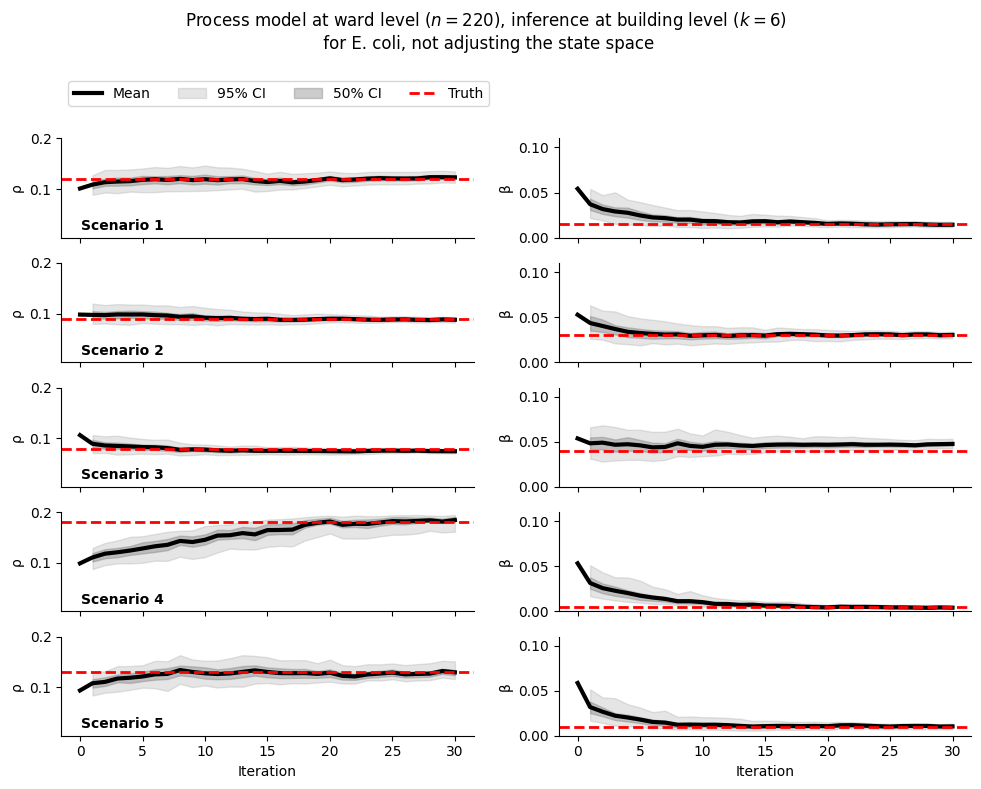

Running IF-EAKF for amro:  K. pneumoniae
Running IF-EAKF for amro:  P. aeruginosa
Running IF-EAKF for amro:  MSSA
Running IF-EAKF for amro:  MRSA
Running IF-EAKF for amro:  S. epidermidis
Running IF-EAKF for amro:  E. faecalis
Running IF-EAKF for amro:  E. faecium


In [3]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 1


amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

from utils_local.misc import amro2title, amro2cute
import matplotlib.pyplot as plt

from diagnostic_plots import convergence_plot
from utils import create_df_response

posterior_df = pd.DataFrame()

for idx_amro, amro in enumerate(amro_search):
    print("Running IF-EAKF for amro: ", amro2title(amro))
    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    fig, axes    = plt.subplots(5, 2, figsize=(10, 8), sharex=True, sharey="col")

    idx_plt = -1
    for idx_row, row in scenarios_df.iterrows():
        try:
            inference = np.load(os.path.join(path_to_save, "infer_building",
                                        f"scenario{idx_row+1}", f"{str(id_run).zfill(3)}posterior.npz"))
            idx_plt += 1
        except:
            continue

        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        y_sim     = inference["observations"]
        θtruth    = inference["teta_truth"]
        idx_infer = inference["idx_infer"]
        Nif       = θpost.shape[-1]

        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter", "amro"])
        post_df["value"]       = np.concatenate([ρ_post, β_post])
        post_df["value_truth"] = np.concatenate([θtruth[0, 0]*np.ones_like(ρ_post), θtruth[1, 0]*np.ones_like(β_post)])

        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
        post_df["amro"]     = amro
        post_df["scenario"] = idx_row

        posterior_df        = pd.concat([posterior_df, post_df])

        ρ_df = create_df_response(θpost[0, :, :, :].mean(-2).T, time=Nif)
        β_df = create_df_response(θpost[1, :, :, :].mean(-2).T, time=Nif)

        p_dfs             = [ρ_df, β_df]
        param_label       = ["ρ", "β"]

        parameters_range  = np.array([[0.01/2, 20/100], [0, 0.11]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[idx_plt, :], fig=fig, param_truth=list(θtruth[:, 0]))

        axes[idx_plt, 0].legend().remove(); axes[idx_plt, 1].legend().remove()
        axes[idx_plt, 1].set_xlabel(None)

        axes[idx_plt, 0].spines['right'].set_visible(False)
        axes[idx_plt, 0].spines['top'].set_visible(False)

        axes[idx_plt, 1].spines['right'].set_visible(False)
        axes[idx_plt, 1].spines['top'].set_visible(False)
        axes[idx_plt, 0].text(x=0.1, y=0.02, s=f"Scenario {idx_plt+1}", weight='bold')

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.65), ncol=4)
    axes[idx_plt, 0].set_xlabel("Iteration")
    axes[idx_plt, 1].set_xlabel("Iteration")

    fig.suptitle(f"Process model at ward level ($n=220$), inference at building level ($k=6$)\n for {amro2title(amro)}, not adjusting the state space", x=0.5)
    plt.tight_layout()
    fig.savefig(os.path.join(path_to_save, "infer_building", "no_shrinking_convergence_plot_all.png"), dpi=300, bbox_inches="tight")

    if amro2title(amro) == "E. coli":
        plt.show()
    else:
        plt.close()

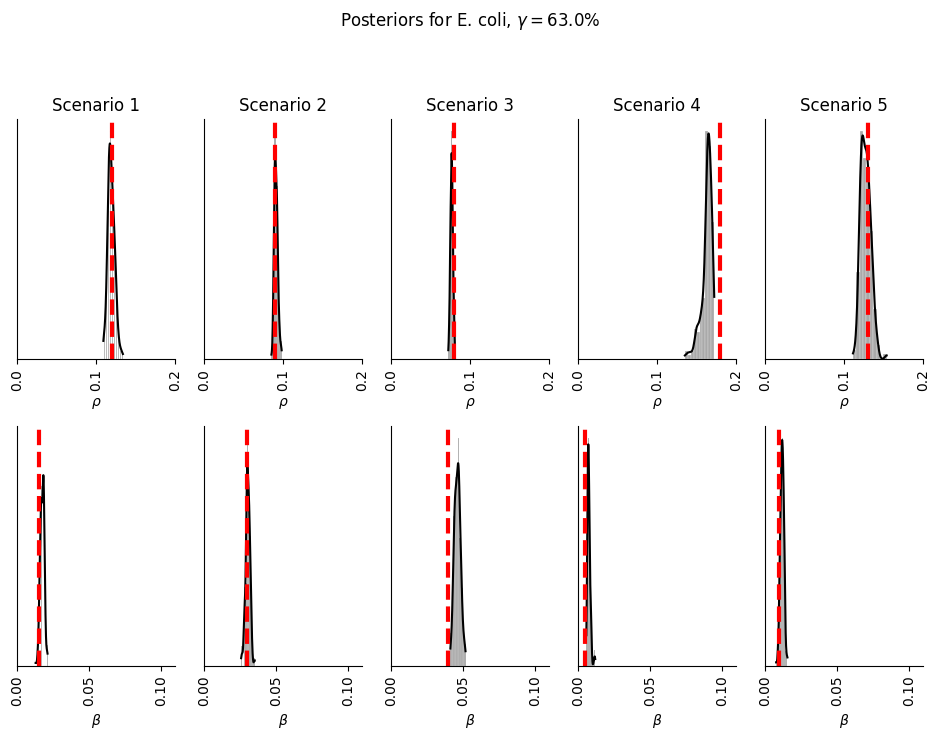

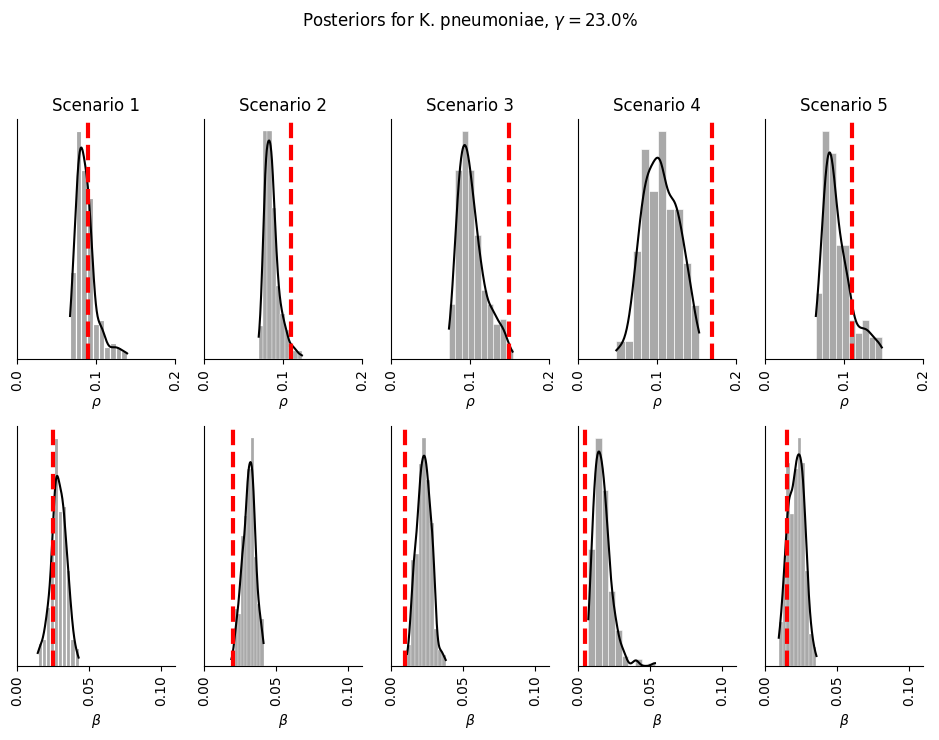

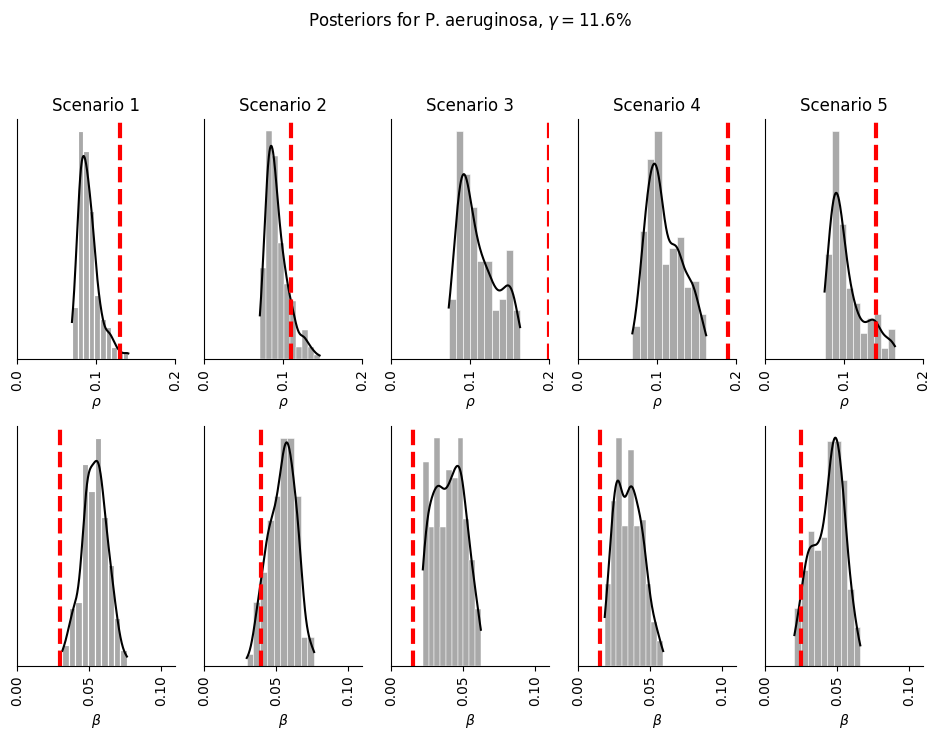

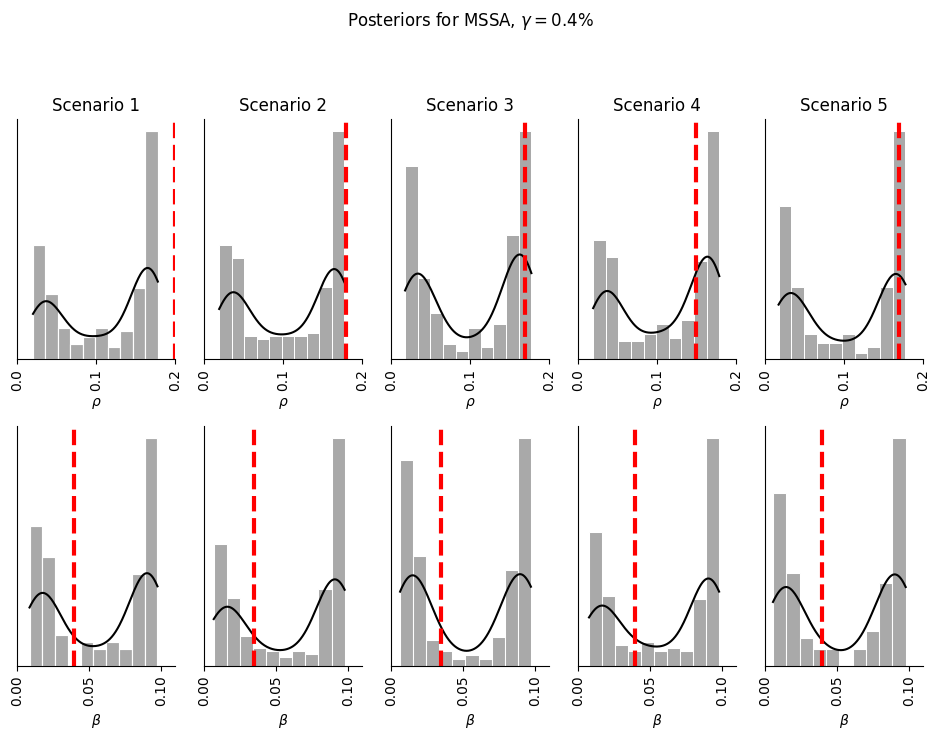

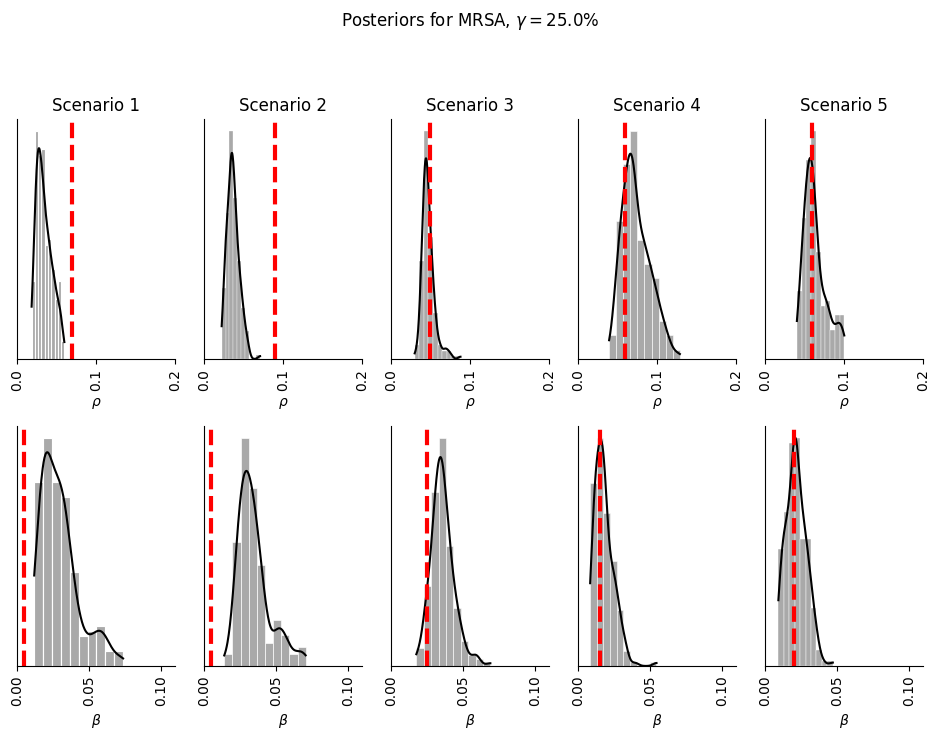

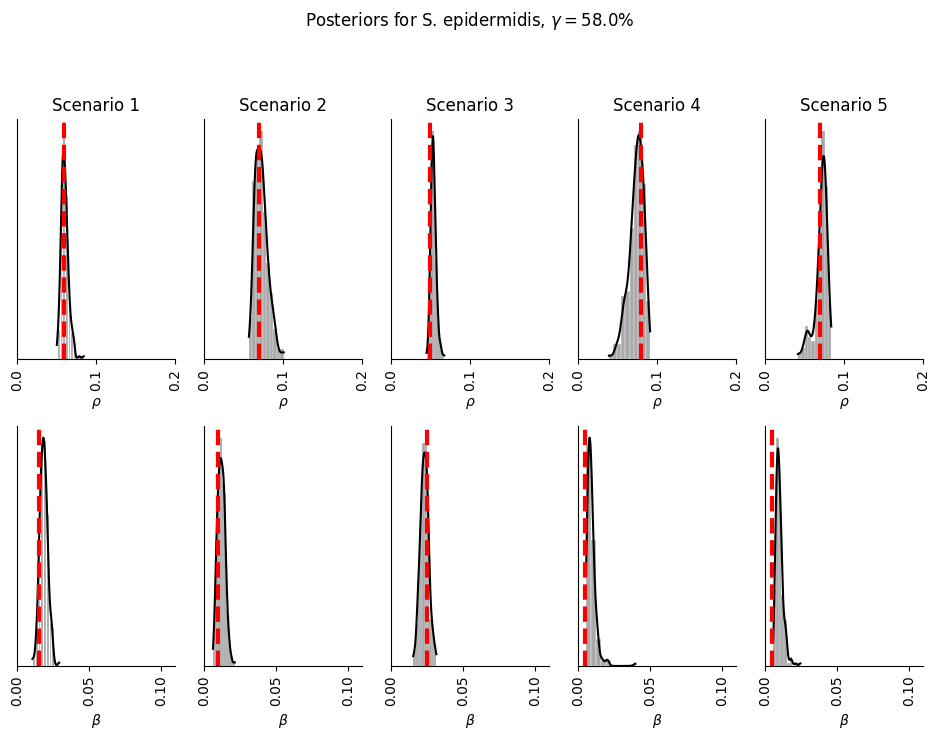

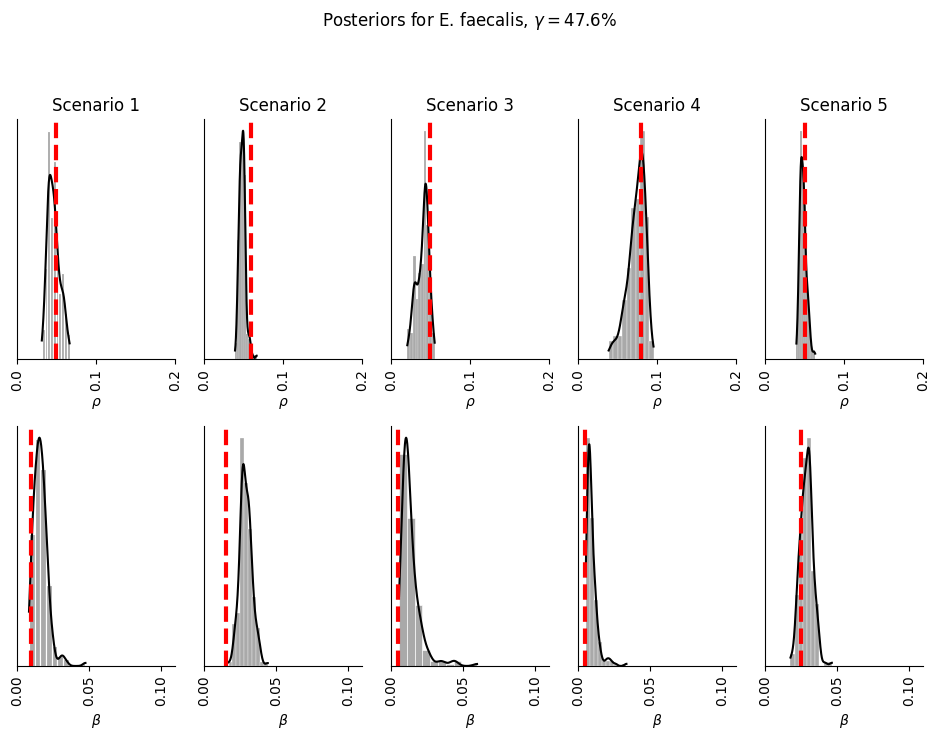

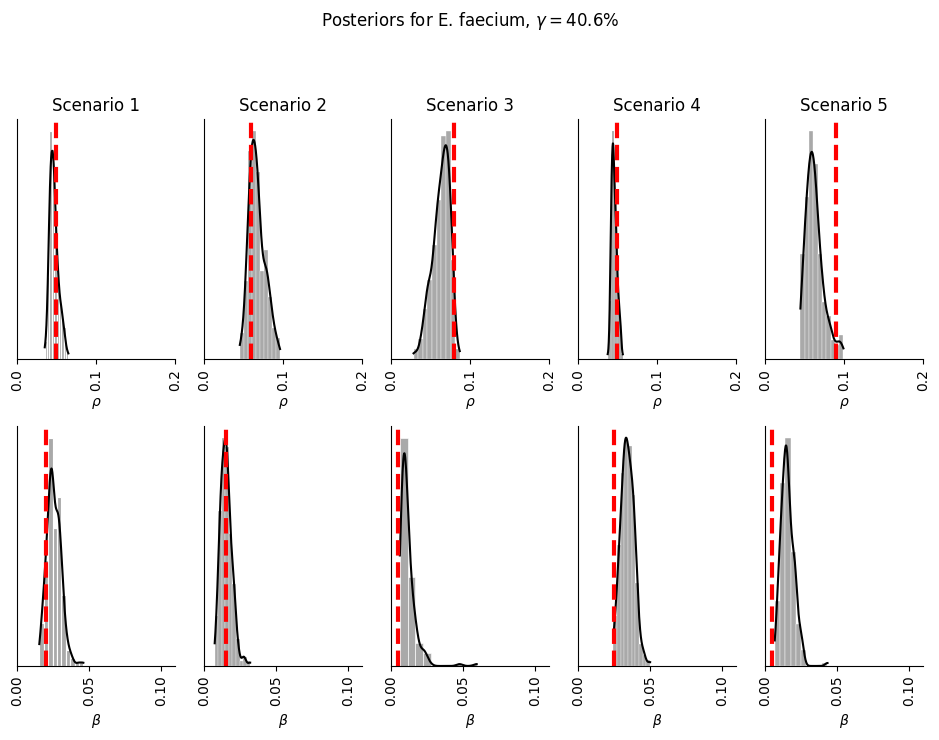

In [4]:
import seaborn as sns

for amro in amro_search:

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    fig, axes    = plt.subplots(2, 5, figsize=(9.5, 7), sharex="row", sharey=False)

    idx_plt = -1
    for idx_row, row in scenarios_df.iterrows():
        ax = axes.flatten()[idx_row]

        try:
            inference = np.load(os.path.join(path_to_save, "infer_building",
                                        f"scenario{idx_row+1}", f"{str(id_run).zfill(3)}posterior.npz"))
            idx_plt += 1
        except:
            continue

        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        θtruth    = inference["teta_truth"]

        sns.histplot(ax=axes[0, idx_plt], x=np.squeeze(θpost[0, :, :, 3:].mean(-2).mean(-1)), color="k", lw=3, stat="density", kde=True, bins=10, edgecolor="w", facecolor="darkgrey")
        axes[0, idx_plt].axvline(θtruth[0, [0]], color="red", ls="--", lw=3)

        sns.histplot(ax=axes[1, idx_plt], x=np.squeeze(θpost[1, :, :, 3:].mean(-2).mean(-1)), color="k", lw=3, stat="density", kde=True, bins=10, edgecolor="w", facecolor="darkgrey")
        axes[1, idx_plt].axvline(θtruth[1, [0]], color="red", ls="--", lw=3)

        axes[0, idx_plt].set_title(f"Scenario {idx_plt+1}")

        axes[1, idx_plt].set_xlabel(r"$\beta$")
        axes[0, idx_plt].set_xlabel(r"$\rho$")

        axes[1, idx_plt].set_xlim(0, 0.11)
        axes[0, idx_plt].set_xlim(0, 0.20)

    for axi in axes.flatten():
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.yaxis.set_visible(False)
        axi.tick_params(axis="x", rotation=90)

    fig.suptitle("Posteriors for {}, $\gamma=${:.1f}%".format(amro2title(amro), gamma*100), x=0.5, y=1.05)
    plt.tight_layout()

    fig.savefig(os.path.join(path_to_save, f"without_shrinking_{amro2cute(amro)}_marginal_individual_observation.png"), dpi=300, bbox_inches='tight', transparent=True)


In [6]:
import matplotlib.ticker as mtick

v_df              = posterior_df[posterior_df["if_iter"] == Nif-1]
v_df["amro_plot"] = v_df["amro"].map( amro2title )

for idx_amro, amro in enumerate(amro_search):
    gamma        = empirical_prevalence(amro_search[idx_amro], path_to_prev="../data/amro_prevalence.csv")

    fig, axes = plt.subplots(1, 5, figsize=(12.2, 5.2), sharey=False, sharex=False)
    for idx_scenario, ax in enumerate(axes.flatten()):
        p_df             = v_df[v_df.amro==amro]
        p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
        rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
        beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
        rho_df["value"]  = rho_df["value"] * 100

        sns.kdeplot(ax    = ax,
                    x     = rho_df["value"],
                    y     = beta_df["value"],
                    cmap  = "Reds",
                    fill  = True,  thresh=0)

        ax.scatter(x          = rho_df["value"],
                    y         = beta_df["value"],
                    facecolor = "mediumpurple",
                    edgecolor = "k", alpha=0.2, s=10)

        ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                    y         = beta_df["value_truth"].drop_duplicates(),
                    marker    = "x",
                    facecolor = "dodgerblue",
                    lw        = 3,
                    s         = 100)


        ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_title("Scenario {}".format(idx_scenario))
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    fig.suptitle("Posterior joint distribution for {}, $\gamma=${:0.1f}%".format(amro2title(amro), gamma*100), x=0.5, y=1.05)

    axes[0].set_ylabel(r"$\beta$")
    for i in range(4):
        axes[i].set_xlabel(r"$\rho$")
    plt.tight_layout()

    fig.savefig(os.path.join(path_to_save, "not_shrinking_posterior_joint_distribution_{}.png".format(amro2cute(amro))), dpi=300, bbox_inches='tight', transparent=True)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_11456/1518797070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df["amro_plot"] = v_df["amro"].map( amro2title )
